Plots to show how the methods work for highly eccentric seob waveforms

In [1]:
import sys
sys.path.append("../../")
%load_ext autoreload
%autoreload 2

In [2]:
from measureEccentricity.measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform
from measureEccentricity.plot_settings import use_fancy_plotsettings, colorsDict, figWidthsOneColDict, lstyles, lwidths
import matplotlib.pyplot as plt
import numpy as np
from measureEccentricity.utils import get_peak_via_quadratic_fit
import matplotlib as mpl
import warnings

/home1/md.shaikh/miniconda3/envs/teobJun22/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/teobJun22/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [3]:
available_param_sets = {
    "1": [1, 0, 0],
    "2": [2, 0.5, 0.5],
    "3": [4, -0.6, -0.6],
    "4": [6, 0.4, -0.4]}

### Create TEOBResumS waveforms

In [4]:
import lalsimulation as lalsim
import lal

In [5]:
sys.path.append("/home1/md.shaikh/teobJun22/Python/")
import EOBRun_module

In [6]:
def generate_teob_22_mode(ecc=0.01,
                          q=1.0,
                          chi1=0.0,
                          chi2=0.0,
                          M=50.0,
                          srate_interp=4096,
                          domain=0, # for time domain
                          arg_out=1, # get hlm also returned
                          use_mode=[1], # use 22 mode
                          output_lm=[1], # get 22 mode only
                          use_geometric_units=1, # get geometric units
                          initial_frequency=0.01 # initial frequency in geometric units
                         ):
    pars = {
    'M'                  : M,
    'q'                  : q,
    'chi1'               : chi1,
    'chi2'               : chi2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'domain'             : domain,      #Set 1 for FD. Default = 0
    'arg_out'            : arg_out,      #Output hlm/hflm. Default = 0
    'use_mode_lm'        : use_mode,    #List of modes to use/output through EOBRunPy
    'output_lm'          : output_lm,    #List of modes to print on file
    'srate_interp'       : srate_interp,  #srate at which to interpolate. Default = 4096.
    'use_geometric_units': use_geometric_units,      #output quantities in geometric units. Default = 1
    'df'                 : 0.01,   #df for FD interpolation
    'initial_frequency'  : initial_frequency,     #in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      #interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'ecc'                : ecc,     #Eccentricity. Default = 0.
    'ecc_freq'           : 2,      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1
    }
    t, hp, hcm, hlm, dyn = EOBRun_module.EOBRunPy(pars)
    amp22 = hlm["1"][0]
    phase22 = hlm["1"][1]
    
    t = t - get_peak_via_quadratic_fit(t, amp22)[0]
    
    data = {"t": t, "hlm": {(2, 2): amp22 * np.exp(- 1j * phase22)}}
    
    # add zero ecc data    
    pars.update({"ecc": 1e-10})
    if ecc >= 1e-1:
        pars.update({"initial_frequency": 0.002})
    t, hp, hcm, hlm, dyn = EOBRun_module.EOBRunPy(pars)
    amp22 = hlm["1"][0]
    phase22 = hlm["1"][1]
    
    t = t - get_peak_via_quadratic_fit(t, amp22)[0]
    num = 1
    while t[0] > (data["t"][0] - 1):
        pars.update({"ecc": 1e-10, "initial_frequency": pars["initial_frequency"] * 0.9})
        t, hp, hcm, hlm, dyn = EOBRun_module.EOBRunPy(pars)
        amp22 = hlm["1"][0]
        phase22 = hlm["1"][1]
    
        t = t - get_peak_via_quadratic_fit(t, amp22)[0]
        num += 1
    
    if num >= 2:
        warnings.warn(f"Too many tries, number of tries {num}")
    
    start = np.argmin(np.abs(t - (data["t"][0] - 1)))
    
    data.update({"t_zeroecc": t[start:], "hlm_zeroecc": {(2, 2): amp22[start:] * np.exp(- 1j * phase22[start:])}})
    
    return data

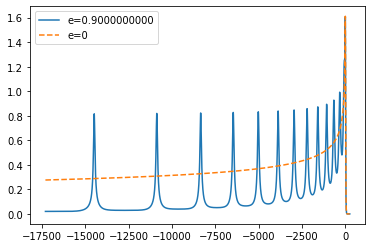

In [7]:
ecc = 9e-1
dataDict = generate_teob_22_mode(ecc=ecc, initial_frequency=0.00005)
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), c="C0", label=f"e={ecc:.10f}")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), c="C1", label="e=0", ls="--")
plt.legend()

In [8]:
dataDict["t_zeroecc"]

array([-17313.10385072, -17312.60385072, -17312.10385072, ...,
          256.39614928,    256.89614928,    257.39614928])

In [9]:
ecc = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]
freq = np.array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.002, 0.0017, 0.0013, 0.0009, 0.0007, 0.00045, 0.00028, 0.00013, 0.00005])

In [10]:
from scipy.interpolate import InterpolatedUnivariateSpline
inv_freq_of_ecc = InterpolatedUnivariateSpline(ecc, 1 / freq)

In [11]:
1 / inv_freq_of_ecc(1e-7)

0.0024999999999999953

### measure eccentricity

In [32]:
dataDict = generate_teob_22_mode(1e-7, 1/inv_freq_of_ecc(1e-7))
tref_in = dataDict["t"]
tref, ecc, mean_ano, eccMethod = measure_eccentricity(tref_in=tref_in,
                                                     method="ResidualAmplitude",
                                                     dataDict=dataDict,
                                                     return_ecc_method=True)

/tmp/ipykernel_1267503/2435822276.py:61: UserWarning: Too many tries, number of tries 2
  warnings.warn(f"Too many tries, number of tries {num}")
../../measureEccentricity/eccDefinition.py:453: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


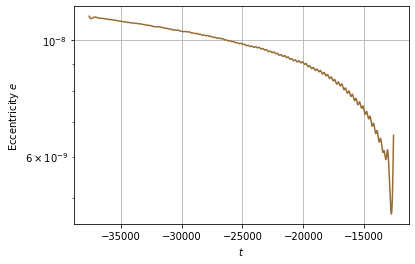

In [35]:
fig, ax = eccMethod.plot_measured_ecc()
ax.set_yscale("log")

### Now we measure the eccentricities of SEOB waveforms

In [71]:
EOBeccs = 10.0**np.linspace(-7.0, 0.0, 150)
EOBeccs = EOBeccs[EOBeccs <= 0.95]
EOBeccs = EOBeccs[0:150:2]
min(EOBeccs), max(EOBeccs)

(1e-07, 0.8974704009584349)

In [72]:
param_key = "1"
params = available_param_sets[param_key]
q, chi1, chi2 = params

In [73]:
from tqdm import tqdm

In [74]:
waveform_eccs = []
model_eccs = [] 
method = "ResidualAmplitude"

data_dir = "../../data/ecc_waveforms/Non-Precessing/EOB/"
Momega0 = 0.01
Momega0_zeroecc = 0.002
meanAno = np.pi/2

for ecc in tqdm(EOBeccs):
    fileName = (f"{data_dir}/EccTest_q{q:.2f}_chi1z{chi1:.2f}_"
                f"chi2z{chi2:.2f}_EOBecc{ecc:.10f}_"
                f"Momega0{Momega0:.3f}_meanAno{meanAno:.3f}.h5")
    kwargs = {"filepath": fileName}
    if "Residual" in method:
        fileName_zero_ecc = (
            f"{data_dir}/EccTest_q{q:.2f}_chi1z"
            f"{chi1:.2f}_"
            f"chi2z{chi2:.2f}_EOBecc{0:.10f}_"
            f"Momega0{Momega0_zeroecc:.3f}_meanAno{meanAno:.3f}.h5")
        kwargs.update({"filepath_zero_ecc": fileName_zero_ecc,
                        "include_zero_ecc": True})
    dataDict = load_waveform(catalog="EOB", **kwargs)
    tref_in = dataDict["t"]
    try:
        tref_out, measured_ecc, mean_ano = measure_eccentricity(
            tref_in=tref_in,
            dataDict=dataDict,
            method=method,
            extra_kwargs={"debug": False})
            # Get the measured eccentricity at the first available index.
            # This corresponds to the first extrema that occurs after the
            # initial time.
        waveform_eccs.append(measured_ecc[0])
        model_eccs.append(ecc)
    except Exception:
        warnings.warn("Exception raised. Probably too small eccentricity "
                    "to detect any extrema.")

  0%|                                                                                                                                                                                       | 0/75 [00:00<?, ?it/s]../../measureEccentricity/eccDefinition.py:453: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")
 31%|█████████████████████████████████████████████████████▎                                                                                                                        | 23/75 [00:15<00:35,  1.47it/s]../../measureEccentricity/eccDefinition.py:392: UserWarning: At least a pair of peaks are too close. Minimum orbital phase diff is 2.990962220343164. Times of occurances are [-445.58938594]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
../../measureEccentricity/eccDefinition.py:398: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
../../measureEccentr

### Now for TEOBResumS

In [75]:
tEOBeccs = []
measuredtEOBeccs = []
for ecc_in in tqdm(EOBeccs):
    dataDict = generate_teob_22_mode(ecc=ecc_in, initial_frequency=1/inv_freq_of_ecc(ecc_in))
    tref_in = dataDict["t"]
    try:
        tref, ecc, mean_ano, eccMethod = measure_eccentricity(tref_in=tref_in,
                                                     method="ResidualAmplitude",
                                                     dataDict=dataDict,
                                                     return_ecc_method=True)
        tEOBeccs.append(ecc_in)
        measuredtEOBeccs.append(ecc[0])
    except Exceptionption:
        print(f"Measurement failed for {ecc_in}")

  0%|                                                                                                                                                                                       | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_1267503/2435822276.py:61: UserWarning: Too many tries, number of tries 2
  warnings.warn(f"Too many tries, number of tries {num}")
../../measureEccentricity/eccDefinition.py:453: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [02:30<00:00,  2.00s/it]


### Save data

In [77]:
import pandas as pd

In [78]:
df = pd.DataFrame({"model_ecc": model_eccs,
                  "SEOB_measured_ecc": waveform_eccs,
                  "TEOB_measured_ecc": measuredtEOBeccs})

In [79]:
df

,model_ecc,SEOB_measured_ecc,TEOB_measured_ecc
0,1.000000e-07,0.000008,6.227867e-07
1,1.241537e-07,0.000008,6.231381e-07
2,1.541415e-07,0.000008,6.231284e-07
3,1.913724e-07,0.000008,6.233500e-07
4,2.375959e-07,0.000008,6.231089e-07
...,...,...,...
70,3.777298e-01,0.289390,2.912790e-01
71,4.689655e-01,0.364825,3.670322e-01
72,5.822382e-01,0.464001,4.680458e-01
73,7.228703e-01,0.599268,6.119623e-01


In [81]:
df.to_csv("../../data/model_eccs_vs_measured_ecc.csv", index=False)

In [82]:
data = pd.read_csv("../../data/model_eccs_vs_measured_ecc.csv")

In [83]:
data

,model_ecc,SEOB_measured_ecc,TEOB_measured_ecc
0,1.000000e-07,0.000008,6.227867e-07
1,1.241537e-07,0.000008,6.231381e-07
2,1.541415e-07,0.000008,6.231284e-07
3,1.913724e-07,0.000008,6.233500e-07
4,2.375959e-07,0.000008,6.231089e-07
...,...,...,...
70,3.777298e-01,0.289390,2.912790e-01
71,4.689655e-01,0.364825,3.670322e-01
72,5.822382e-01,0.464001,4.680458e-01
73,7.228703e-01,0.599268,6.119623e-01


In [84]:
use_fancy_plotsettings()

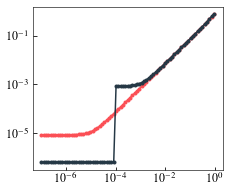

In [89]:
fig, ax = plt.subplots(figsize=(figWidthsOneColDict["APS"], 3))
ax.loglog(data["model_ecc"], data["SEOB_measured_ecc"], marker=".")
ax.loglog(data["model_ecc"], data["TEOB_measured_ecc"], marker=".")